In [21]:
# Install dependencies
!pip install plotly seaborn xgboost shap -q

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime as dt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import shap

In [4]:
customers = pd.read_csv("olist_customers_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")

In [5]:
# Convert to datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])

# Remove missing delivery dates (undelivered orders)
orders_clean = orders.dropna(subset=['order_delivered_customer_date'])

In [6]:
orders_cohort = orders_clean.merge(customers, on='customer_id')

# Cohort monthly
orders_cohort['order_month'] = orders_cohort['order_purchase_timestamp'].dt.to_period('M')
orders_cohort['cohort_month'] = orders_cohort.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')

In [7]:
def cohort_period(df):
    return (df.order_month - df.cohort_month).apply(lambda x: x.n)

orders_cohort['cohort_index'] = cohort_period(orders_cohort)

In [8]:
cohort_pivot = (
    orders_cohort
    .groupby(['cohort_month', 'cohort_index'])['customer_unique_id']
    .nunique()
    .reset_index()
    .pivot(index='cohort_month', columns='cohort_index', values='customer_unique_id')
)

cohort_pivot.fillna(0, inplace=True)
cohort_pivot


cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_month,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-10,267.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,2.0
2016-12,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01,717.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,0.0,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0,0.0
2017-02,1628.0,3.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,3.0,0.0,0.0
2017-03,2503.0,11.0,9.0,10.0,9.0,4.0,4.0,8.0,8.0,2.0,9.0,3.0,5.0,3.0,4.0,6.0,2.0,3.0,0.0,0.0
2017-04,2256.0,14.0,5.0,4.0,6.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,1.0,1.0,2.0,2.0,3.0,0.0,0.0,0.0
2017-05,3450.0,16.0,16.0,10.0,10.0,11.0,14.0,5.0,9.0,9.0,9.0,12.0,8.0,1.0,6.0,7.0,0.0,0.0,0.0,0.0
2017-06,3037.0,15.0,12.0,13.0,9.0,12.0,11.0,7.0,4.0,6.0,9.0,11.0,5.0,5.0,7.0,0.0,0.0,0.0,0.0,0.0


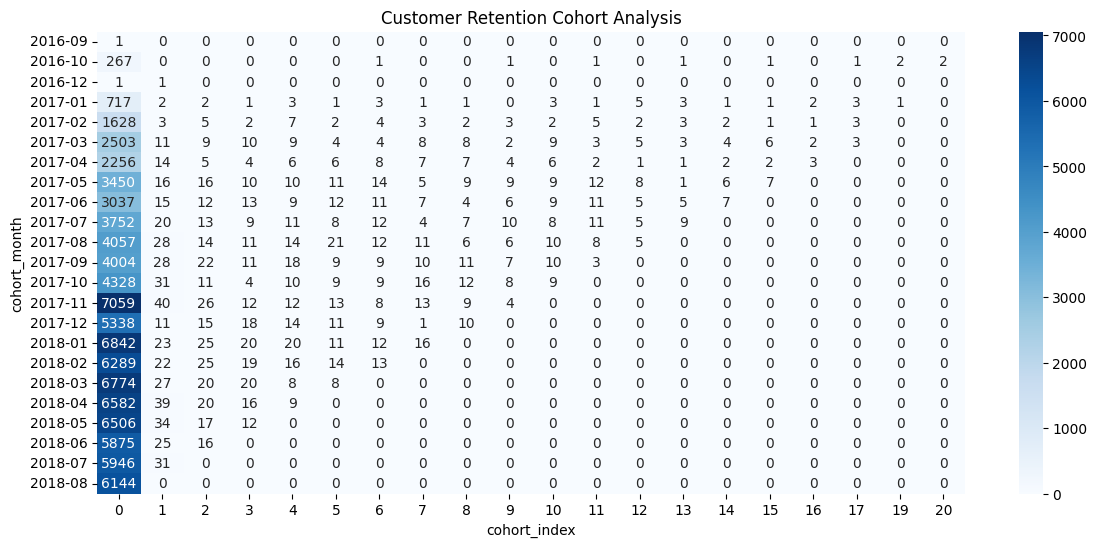

In [9]:
plt.figure(figsize=(14, 6))
sns.heatmap(cohort_pivot, annot=True, fmt='.0f', cmap='Blues')
plt.title("Customer Retention Cohort Analysis")
plt.show()

In [14]:
# Merge orders with customers to get customer_unique_id
orders_clean_merge = orders_clean.merge(customers, on="customer_id", how="left")

last_date = orders_clean_merge['order_purchase_timestamp'].max()

customer_orders = (
    orders_clean_merge.groupby('customer_unique_id')['order_purchase_timestamp']
    .max()
    .reset_index()
)

customer_orders['days_since_last_order'] = (
    last_date - customer_orders['order_purchase_timestamp']
).dt.days

customer_orders['churn'] = (customer_orders['days_since_last_order'] > 90).astype(int)

customer_orders.head()


,customer_unique_id,order_purchase_timestamp,days_since_last_order,churn
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,111,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,114,1
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,536,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,320,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,287,1


In [22]:
# Use merged table for all customer-level calculations
df = orders_clean_merge.copy()

# RECENCY
recency = customer_orders[['customer_unique_id', 'days_since_last_order']].rename(
    columns={'days_since_last_order':'recency'}
)

# FREQUENCY
frequency = (
    df.groupby('customer_unique_id')['order_id']
    .count()
    .reset_index()
    .rename(columns={'order_id':'frequency'})
)

# MONETARY
monetary = (
    order_items.groupby('order_id')['price'].sum().reset_index()
    .merge(df[['order_id','customer_unique_id']], on='order_id', how='left')
    .groupby('customer_unique_id')['price'].sum()
    .reset_index()
    .rename(columns={'price':'monetary'})
)

# MERGE RFM
rfm = recency.merge(frequency, on='customer_unique_id')
rfm = rfm.merge(monetary, on='customer_unique_id')
rfm = rfm.merge(customer_orders[['customer_unique_id','churn']], on='customer_unique_id')

rfm.head()


,customer_unique_id,recency,frequency,monetary,churn
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,1
2,0000f46a3911fa3c0805444483337064,536,1,69.00,1
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99,1
4,0004aac84e0df4da2b147fca70cf8255,287,1,180.00,1


In [23]:
X = rfm[['recency','frequency','monetary']]
y = rfm['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3723
           1       1.00      1.00      1.00     14949

    accuracy                           1.00     18672
   macro avg       1.00      1.00      1.00     18672
weighted avg       1.00      1.00      1.00     18672



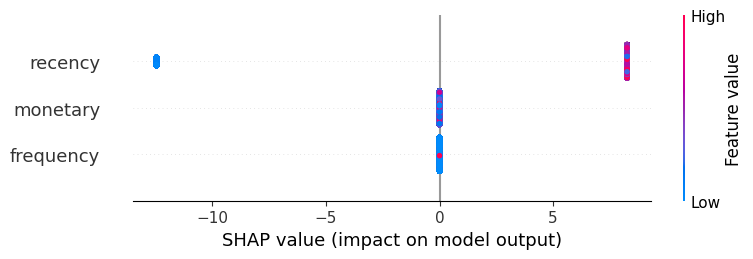

In [24]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)


In [25]:
cohort_pivot.to_csv("cohort_table.csv", index=True)
rfm.to_csv("rfm_table.csv", index=False)

from google.colab import files
files.download("cohort_table.csv")
files.download("rfm_table.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>